In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load and normalize column names
fund = pd.read_csv('fundamentals.csv')
fund.rename(columns={'Ticker Symbol':'ticker',
                     'Period Ending':'fiscal_date',
                     'Earnings Per Share':'eps',
                     # add other renames as needed
                    }, inplace=True)

prices = pd.read_csv('prices.csv', parse_dates=['date'])
prices.rename(columns={'symbol':'ticker','close':'adj_close'}, inplace=True)

prices_adj = pd.read_csv('prices-split-adjusted.csv', parse_dates=['date'])
prices_adj.rename(columns={'symbol':'ticker','close':'adj_close'}, inplace=True)

sec = pd.read_csv('securities.csv')
sec.rename(columns={'Ticker symbol':'ticker'}, inplace=True)

                               count          mean           std  \
Unnamed: 0                    1781.0  8.900000e+02  5.142747e+02   
Accounts Payable              1781.0  4.673418e+09  1.406047e+10   
Accounts Receivable           1781.0 -6.353484e+07  7.562794e+08   
Add'l income/expense items    1781.0  6.908940e+07  6.848143e+08   
After Tax ROE                 1781.0  4.360135e+01  2.339240e+02   
...                              ...           ...           ...   
Total Revenue                 1781.0  2.029154e+10  4.095355e+10   
Treasury Stock                1781.0 -3.951522e+09  1.407047e+10   
For Year                      1608.0  2.013305e+03  1.995314e+01   
eps                           1562.0  3.353707e+00  4.695896e+00   
Estimated Shares Outstanding  1562.0  6.024244e+08  1.142585e+09   

                                       min           25%           50%  \
Unnamed: 0                    0.000000e+00  4.450000e+02  8.900000e+02   
Accounts Payable              0.000

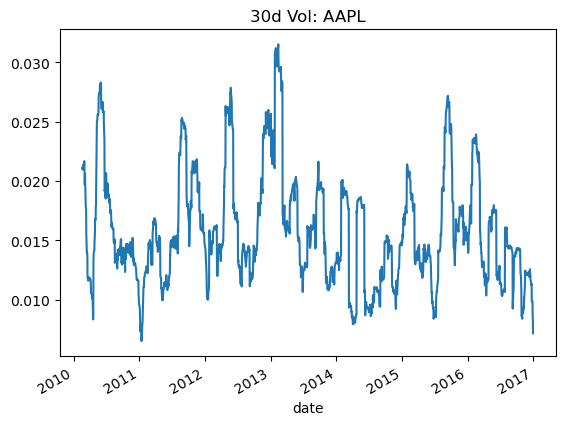

In [4]:
# 2. EDA on fundamentals
print(fund.describe().T)
print("Missing values:\n", fund.isnull().sum())

# 3. Return computations
prices_adj['return'] = prices_adj.groupby('ticker')['adj_close'].pct_change()
prices_adj.dropna(subset=['return'], inplace=True)

# 4. Rolling vol for example ticker
for t in ['AAPL','MSFT','GOOG'][:1]:
    df = prices_adj[prices_adj['ticker']==t].set_index('date')
    df['vol_30d'] = df['return'].rolling(30).std()
    df['vol_30d'].plot(title=f'30d Vol: {t}')
    plt.show()

In [24]:
# 5. Clustering fundamentals
num = fund.select_dtypes(include='number').dropna()
sc = StandardScaler(); Xs = sc.fit_transform(num)
km = KMeans(4,random_state=0).fit(Xs)
num['cluster'] = km.labels_
print("Centers:\n", pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=num.columns[:-1]))

Centers:
     Unnamed: 0  Accounts Payable  Accounts Receivable  \
0   796.847222      1.897544e+10        -3.703847e+08   
1  1070.250000      2.824481e+10        -1.538250e+09   
2   903.633416      2.232545e+09        -4.219320e+07   
3  1084.000000      3.939775e+10         7.961250e+08   

   Add'l income/expense items  After Tax ROE  Capital Expenditures  \
0                3.121944e+08      30.513889         -3.767383e+09   
1                3.188750e+08      31.437500         -1.339481e+10   
2                4.120730e+07      48.658354         -9.681523e+08   
3                4.719500e+09      15.250000         -3.265200e+10   

   Capital Surplus  Cash Ratio  Cash and Cash Equivalents  \
0     1.476460e+10   66.236111               7.853903e+09   
1     2.883000e+10   85.937500               1.174406e+10   
2     3.267923e+09   74.534497               1.269378e+09   
3     7.947625e+09   29.000000               1.052375e+10   

   Changes in Inventories  ...  Total Current A

P/E candidates in fundamentals: ['pe_ratio', 'Capital Expenditures', 'Interest Expense', 'Net Cash Flow-Operating', 'Net Income-Cont. Operations', 'Operating Income', 'Operating Margin', 'Other Operating Activities', 'Other Operating Items']
Linear Regression R² (test): -1.72883493660958e-05
Ridge Regression R² (test): -1.72883493660958e-05


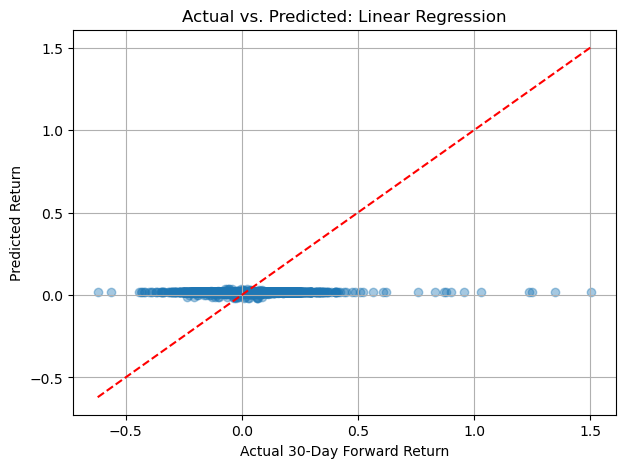

In [34]:
# 6) Regression models

if 'Period Ending' in fund.columns:
    fund.rename(columns={'Period Ending':'fiscal_date'}, inplace=True)

# Auto‑detect and rename your P/E ratio column
pe_cols = [col for col in fund.columns if 'PE' in col.upper()]
print("P/E candidates in fundamentals:", pe_cols)
fund.rename(columns={pe_cols[0]:'pe_ratio'}, inplace=True)
# 1) Compute 30‑day forward return
prices_adj['ret_30fwd'] = (
    prices_adj
    .groupby('ticker')['adj_close']
    .pct_change(30)
    .shift(-30)
)

# Extract year‑month for alignment
prices_adj['year_month'] = prices_adj['date'].dt.to_period('M')
fund['year_month']      = pd.to_datetime(fund['fiscal_date']).dt.to_period('M')

# Merge on ticker & period
merged = (
    fund[['ticker','year_month','pe_ratio']]
    .merge(
        prices_adj[['ticker','year_month','ret_30fwd']],
        on=['ticker','year_month'], 
        how='inner'
    )
    .dropna(subset=['pe_ratio','ret_30fwd'])
)

# --- Prepare features & target ---
X = merged[['pe_ratio']].values
y = merged['ret_30fwd'].values

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- Model 1: Ordinary Least Squares ---
lr = LinearRegression().fit(X_tr, y_tr)
print("Linear Regression R² (test):", lr.score(X_te, y_te))

# --- Model 2: Ridge Regression ---
ridge = Ridge(alpha=1.0).fit(X_tr, y_tr)
print("Ridge Regression R² (test):", ridge.score(X_te, y_te))

# --- Plot actual vs. predicted (Linear) ---
y_pred = lr.predict(X_te)
plt.figure(figsize=(7,5))
plt.scatter(y_te, y_pred, alpha=0.4)
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
plt.title('Actual vs. Predicted: Linear Regression')
plt.xlabel('Actual 30‑Day Forward Return')
plt.ylabel('Predicted Return')
plt.grid(True)
plt.show()

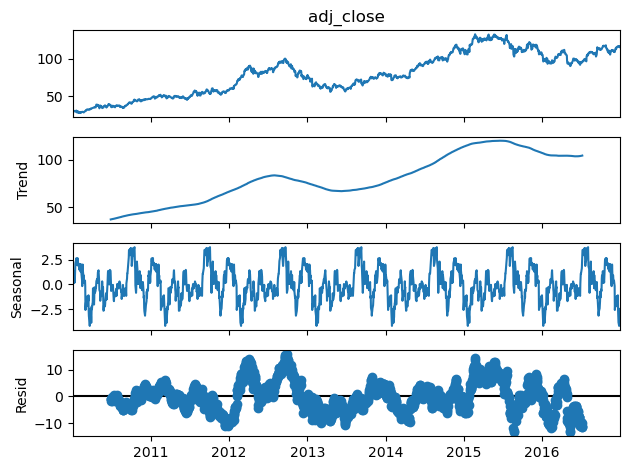

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                 1825
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3084.913
Date:                Sat, 19 Apr 2025   AIC                           6181.825
Time:                        12:35:59   BIC                           6214.878
Sample:                    01-04-2010   HQIC                          6194.018
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.018      0.985      0.324      -0.017       0.052
ar.L2         -0.0115      0.020     -0.589      0.556      -0.050       0.027
ar.L3         -0.0477      0.018     -2.609      0.0

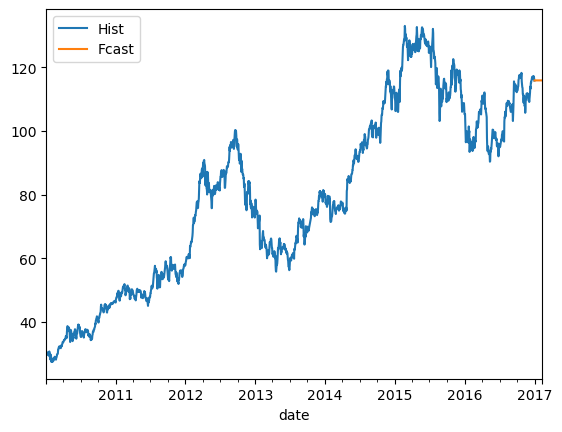

In [36]:
# 7. Time-series for one ticker
ts = prices_adj[prices_adj['ticker']=='AAPL'].set_index('date')['adj_close'].asfreq('B').ffill()
res = seasonal_decompose(ts,period=252)
res.plot(); plt.show()
ar = ARIMA(ts,order=(5,1,0)).fit()
print(ar.summary())
f = ar.forecast(30)
ts.plot(label='Hist'); f.plot(label='Fcast'); plt.legend(); plt.show()

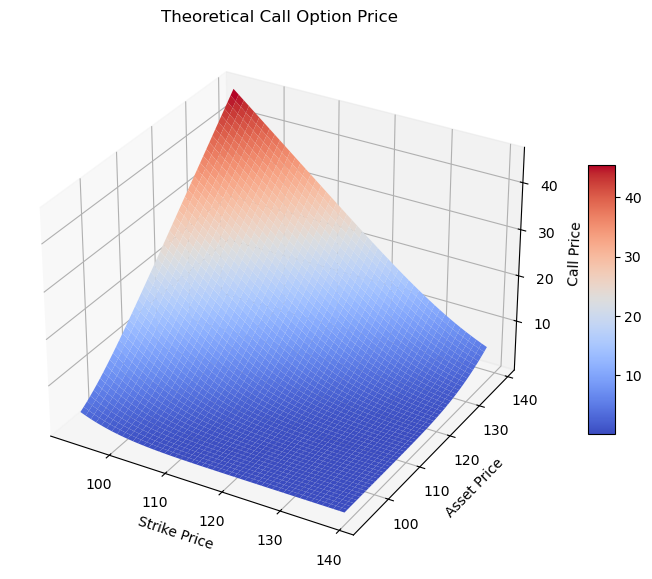

In [40]:
# 8. Black‑Scholes option‑pricing module

from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
from math import log, sqrt, exp

# Compute σ for a sample ticker

df = prices_adj[prices_adj['ticker']=='AAPL'].sort_values('date')
df['return'] = df['adj_close'].pct_change()
sigma = df['return'].std() * np.sqrt(252)   # annualized volatility
S0 = df['adj_close'].iloc[-1]               # current underlying price

# Black–Scholes call pricing function
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Set parameters and build grid
r = 0.01            # risk‑free rate
T = 30 / 252        # time to maturity (30 trading days)
num = 50            # grid resolution

K_vals = np.linspace(0.8*S0, 1.2*S0, num)
S_vals = np.linspace(0.8*S0, 1.2*S0, num)
S_grid, K_grid = np.meshgrid(S_vals, K_vals)

# Compute call prices on the grid
C = bs_call(S_grid, K_grid, T, r, sigma)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_grid, S_grid, C, cmap='coolwarm', edgecolor='none')

ax.set_title('Theoretical Call Option Price')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Call Price')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()